In [1]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 60.4 MB 21 kB/s              
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


#  Трек «CV-инженер»

# Track "CV Engineer"

## ✏️ Проект 1. Угадай знаменитость 

## Project 1. Guess the celebrity

### Выполнил студент DSPR-27 Плюснин Олег

### Performed by the student DSPR-27 Plyusnin Oleg

импортируем бибилиотеки

importing libraries

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import cv2

%matplotlib inline

In [2]:
path_train = 'train/'
path_valid = 'valid/'
# создаем список и словарь меток
# creating a list and dictionary of labels
sub_path = ['bill_gates', 'elon_mask', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']
dict_target = {'bill_gates' : 0,
              'elon_mask' : 1,
              'jeff_bezos' : 2,
              'mark_zuckerberg' : 3,
              'steve_jobs' : 4}

создаем собственный класс Dataset

creating our own Dataset class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, train_flag = 'train', path_train = path_train, path_valid = path_valid):
        if train_flag == 'train':
            self.imgs_path = path_train
        elif train_flag == 'val':
            self.imgs_path = path_valid
        self.data = []
        # задаем размер изображения для нейронной сети
        # setting the image size for the neural network
        self.img_dim = (64, 64)
        self.classes = sub_path

       # Разделим выборку на обучающую и валидационную
       # Let's divide the sample into training and validation 
        if train_flag == 'train':
            for img_path in sub_path:
                for image_name in glob.glob(self.imgs_path + img_path + '/*.jpg'):
                       self.data.append([image_name, dict_target[img_path]])                 
                
          
        elif train_flag == 'val':
            for img_path in sub_path:
                for image_name in glob.glob(self.imgs_path + img_path + '/*.jpg'):
                       self.data.append([image_name, dict_target[img_path]])
         
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Мы используем opencv, чтобы загрузить изображение и изменить его размер до необходимого размера
        # We use opencv to upload an image and resize it to the required size
        img = cv2.imread(img_path)
        img = img[:, :, ::-1]
        img = cv2.resize(img, self.img_dim,  cv2.INTER_AREA)

        
        class_id = class_name
        img_tensor = torch.from_numpy(img)

        # Приведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        # Here is the scaling of the image: convert pixels from 0 to 255 to the format from 0 to 1
        img_tensor = img_tensor/255
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

Параметр train_flag класса CustomDataset позволяет нам выбирать между обучающей и тестовой выборкой

The train_flag parameter of the CustomDataset class allows us to choose between a training and a test sample

In [4]:
#!g1.1
# создаем обучающий и валидационный датасеты
# creating training and validation datasets
train_data = CustomDataset()
val_data = CustomDataset('val')

# разобьем обучающий датасет на тренировочный и тестовый
# let's split the training dataset into training and test
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

# задаем размер батча
# setting the size of the batch
batch_size = 24

# создаем даталоудеры
# creating datalouders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [5]:
#!g1.1
# проверим размер данных
# check the data size
train_data[0][0].size()

torch.Size([3, 64, 64])

Посмотрим на размер train_data с помощью метода len()

Let's look at the size of train_data using the len() method

In [6]:
train_data.__len__()

3000

Отрисуем один батч картинок, загруженных с помощью DataLoader()

Let's draw one batch of images uploaded using DataLoader()

In [7]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

In [8]:
classes = train_data.classes
classes

['bill_gates', 'elon_mask', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

['mark_zuckerberg', 'jeff_bezos', 'jeff_bezos', 'jeff_bezos', 'mark_zuckerberg', 'elon_mask', 'bill_gates', 'bill_gates', 'mark_zuckerberg', 'jeff_bezos', 'steve_jobs', 'jeff_bezos', 'bill_gates', 'elon_mask', 'mark_zuckerberg', 'mark_zuckerberg', 'bill_gates', 'elon_mask', 'steve_jobs', 'elon_mask', 'elon_mask', 'bill_gates', 'jeff_bezos', 'mark_zuckerberg']


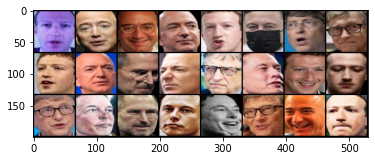

In [9]:
print([classes[i] for i in y_train])
plt.imshow(img)

## Загрузка модели

## Loading the model

Мы будем использовать VGG16 в качестве предобученной сети

We will use VGG 16 as a pre-trained network

In [10]:
#!g1.1
from torchvision.models import vgg16

In [342]:
#!g1.1
model = vgg16(pretrained = True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

Это значит, что мы будем использовать уже обученные веса данной нейронной сети

This means that we will use the already trained weights of this neural network

Заморозка слоев VGG16 сети

Freezing of VG16 network layers

In [343]:
#!g1.1
for param in model.parameters():
    param.requires_grad = False

In [344]:
#!g1.1
# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
# Let's see how many neurons are fed to the input of the output layer of the classifier
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи классификации
# Let's replace this layer with a new one, the output number of neurons of which corresponds to our classification task
num_classes = 5
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


Разморозим классификатор модели, мы будем заново обучать его полностью

We will unfreeze the classifier of the model, we will re-train it completely

In [345]:
#!g1.1
for index, param in enumerate(model.classifier.parameters()):
    param.requires_grad = True

Переносим модель на видеокарту.
В качестве функции потерь используем кроссэнтропию.
Используем оптимизатор Adam.

We transfer the model to the video card.
We use cross entropy as a loss function.
Using the Adam optimizer.

In [346]:
#!g1.1
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

True


## Обучение модели

## Model Training

Для удобства создадим словарь даталоадеров:

For convenience, we will create a dictionary of dataloaders:

In [16]:
#!g1.1
dataloaders = {'train': train_loader,
               'test' : test_loader,
               'val': val_loader}

In [324]:
#!g1.1
def train_model(model, device, dataloaders, criterion, optimizer, batch_size, num_epochs=24):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидация 
        # Training and validation takes place at each epoch
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            # Going through the data
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                # zeroing the gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    # We get the forecast of the model and calculate the loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                # counting statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                # let's look at the statistics for every 10 matches
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))

            if phase == 'train':
                len_dataset = train_size
            else:
                len_dataset = test_size
            epoch_loss = current_loss / len_dataset #CustomDataset(phase).__len__()
            epoch_acc = current_corrects.double() / len_dataset #CustomDataset(phase).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [347]:
#!g1.1
person_model = train_model(model, device, dataloaders, criterion, optimizer, batch_size = batch_size)

Epoch 0/23
----------
Batch 10, Train Loss:2.3010, Train ACC:33.7500
Batch 20, Train Loss:1.8383, Train ACC:45.0000
Batch 30, Train Loss:1.6059, Train ACC:51.9444
Batch 40, Train Loss:1.4519, Train ACC:57.6042
Batch 50, Train Loss:1.2988, Train ACC:62.1667
Batch 60, Train Loss:1.2601, Train ACC:64.1667
Batch 70, Train Loss:1.2112, Train ACC:65.2381
Batch 80, Train Loss:1.1240, Train ACC:67.5521
Batch 90, Train Loss:1.0820, Train ACC:68.9815
Batch 100, Train Loss:1.0575, Train ACC:70.2083
train Loss: 1.0575 Acc: 0.7021
test Loss: 0.4859 Acc: 0.8667
Epoch 1/23
----------
Batch 10, Train Loss:0.8647, Train ACC:80.4167
Batch 20, Train Loss:0.7036, Train ACC:84.3750
Batch 30, Train Loss:0.8580, Train ACC:82.3611
Batch 40, Train Loss:0.7734, Train ACC:83.3333
Batch 50, Train Loss:0.8030, Train ACC:83.2500
Batch 60, Train Loss:0.8530, Train ACC:82.5694
Batch 70, Train Loss:0.8757, Train ACC:82.1429
Batch 80, Train Loss:0.9125, Train ACC:81.7708
Batch 90, Train Loss:0.9135, Train ACC:81.8519
B

## Визуализация модели

## Visualization of the model

In [20]:
#!g1.1
def visualize_model(model, num_images=24):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure(figsize=(15, 15))

    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

проверим нашу модель на валидационных данных

let's test our model on validation data

In [348]:
#!g1.1
current_loss = 0.0
current_corrects = 0
batch = 0
person_model.eval()

# Проходим по данным
# Going through the data
for inputs, labels in dataloaders['val']:
    batch += 1
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        # Получаем прогноз модели и считаем лосс
        # We get the forecast of the model and calculate the loss
        outputs = person_model(inputs)
        _, preds = torch.max(outputs, 1)
        labels = labels.squeeze(-1)
        loss = criterion(outputs, labels)
        
        # считаем статистики
        # counting statistics
    current_loss += loss.item() * inputs.size(0)
    current_corrects += torch.sum(preds == labels)
                
                
            
epoch_loss = current_loss / CustomDataset('val').__len__()
epoch_acc = current_corrects.double() / CustomDataset('val').__len__()


In [349]:
#!g1.1
print(epoch_loss)
print(epoch_acc.item()*100)

0.6505494975292618
95.84245076586433


accuracy на валидационных данных 95%, что удовлетворяет условию задачи

accuracy on the validation data is 95%, which satisfies the condition of the problem

проверка полноты валидации

checking the completeness of validation

In [350]:
#!g1.1
batch * batch_size

936

In [351]:
#!g1.1
CustomDataset('val').__len__()

914

визуализация валидации

visualization of validation

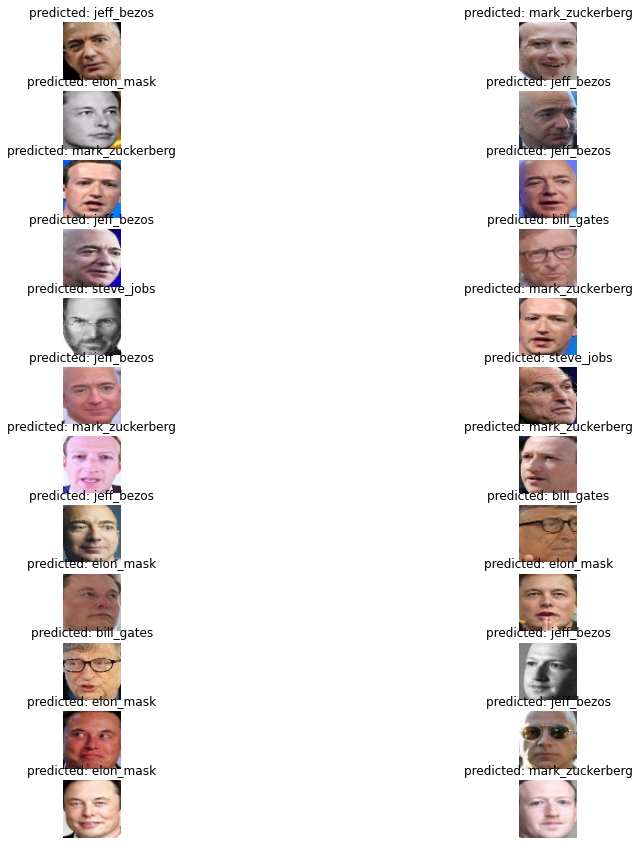

In [352]:
#!g1.1
visualize_model(person_model)
plt.show()

видим одну ошибку на валидации из 24 примеров

we see one error on validation out of 24 examples

### сохраняем модель

### saving the model

In [ ]:
#!g1.1
torch.save(person_model, './person_model')

# Выводы


Для задач классификации существует много предобученных моделей. Их использование намного упрощает и ускоряет процесс разработки моделей без потери качества. В данной работе мы использовали довольно простую нейронную сеть VGG16. Мы переобучили полностью ее классификатор. Это сэкономило много времени и машинных ресурсов. А качество классификации осталось очень высоким. На самом деле, для пяти классов сеть такой сложности не нужна. Достаточно 4-5 слоев свертки и 3-4 слоев классификатора из полносвязных слоев. Но даже такая простая модель обучается дольше в два раза, чем готовая предобученная. Поэтому использование готовых предобученных сетей дает ощутимый выигрыш и весьма целесообразно.